Epoch: 1 	Training Loss: 0.392145
Epoch: 2 	Training Loss: 0.131439
Epoch: 3 	Training Loss: 0.090824
Epoch: 4 	Training Loss: 0.070182
Epoch: 5 	Training Loss: 0.059312
Epoch: 6 	Training Loss: 0.049882
Epoch: 7 	Training Loss: 0.045489
Epoch: 8 	Training Loss: 0.038417
Epoch: 9 	Training Loss: 0.035735
Epoch: 10 	Training Loss: 0.031736


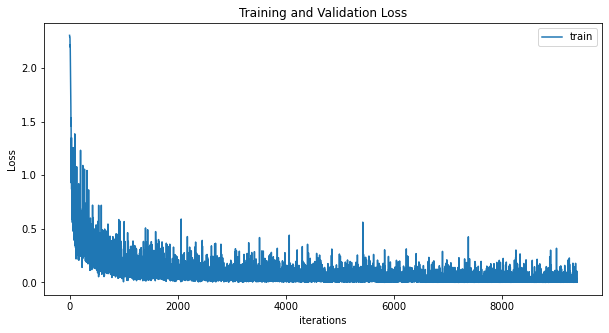

In [31]:

import torch
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import datetime
import time
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

val_losses = []
train_losses = []

torch.manual_seed(73)

train_data = datasets.MNIST(r'./mnist', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(r'./mnist', train=False, download=True, transform=transforms.ToTensor())


batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()        
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        # the model uses the square activation function
        x = x * x
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x


def train(model, train_loader, criterion, optimizer, n_epochs=10):
    # model in training mode
    
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # writer.add_scalar('BaseModel/Loss/train', train_loss, epoch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            train_losses.append(loss.item())
           



        

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # model in evaluation mode

    model.eval()
    return model


model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")

plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Test Loss: 0.084722

Test Accuracy of 0: 99% (971/980)
Test Accuracy of 1: 99% (1131/1135)
Test Accuracy of 2: 97% (1007/1032)
Test Accuracy of 3: 98% (990/1010)
Test Accuracy of 4: 97% (962/982)
Test Accuracy of 5: 98% (876/892)
Test Accuracy of 6: 98% (945/958)
Test Accuracy of 7: 96% (997/1028)
Test Accuracy of 8: 96% (941/974)
Test Accuracy of 9: 96% (972/1009)

Test Accuracy (Overall): 97% (9792/10000)


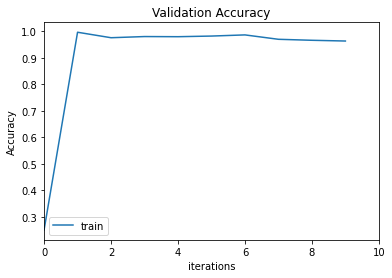

In [35]:
acc = [] 
def test(model, test_loader, criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # model in evaluation mode
    model.eval()

    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        if(label == 0):
          acc.append(0.25)
        else:
          acc.append(class_correct[label] / class_total[label])

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )
test(model, test_loader, criterion)
plt.title("Validation Accuracy")

plt.plot(acc,label="train")
plt.xlabel("iterations")
# plt.ylim(0.5,0.99)
plt.xlim(0,10)
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# print(acc)

In [12]:
part_te = torch.utils.data.random_split(test_data, [600, len(test_data)-600])[0]
test_loader_split = torch.utils.data.DataLoader(part_te, batch_size=batch_size, shuffle=True)
print(len(part_te))

600


In [13]:
!pip install tenseal

     |████████████████████████████████| 4.7MB 5.4MB/s 


In [15]:
enc_val_loss = []
enc_acc = []

In [20]:

"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convlution operation.
    - .square_() just square the encrypted vector inplace.
"""

import tenseal as ts


class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()
        
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        
        
    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    i = 0
    for data, target in test_loader:
        # Encoding and encryption
        i=i+1
        if(i%10 == 0):
          
          t1 = time.time()
          st = datetime.datetime.fromtimestamp(t1).strftime('%H:%M:%S')
          print("test numbers done: ",i, "in",st)
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)
        
        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        enc_val_loss.append(loss.item())
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )
        if(label == 0):
          enc_acc.append(0)
        else:
          enc_acc.append(class_correct[label] / class_total[label])
        

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )


# Load one element at a time
test_loader = torch.utils.data.DataLoader(part_te, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = model.conv1.kernel_size
stride = model.conv1.stride[0]

In [21]:
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

In [22]:
enc_model = EncConvNet(model)



In [24]:
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)

test numbers done:  10 in 06:22:05
test numbers done:  20 in 06:22:57
test numbers done:  30 in 06:23:49
test numbers done:  40 in 06:24:41
test numbers done:  50 in 06:25:33
test numbers done:  60 in 06:26:24
test numbers done:  70 in 06:27:16
test numbers done:  80 in 06:28:08
test numbers done:  90 in 06:29:00
test numbers done:  100 in 06:29:52
test numbers done:  110 in 06:30:44
test numbers done:  120 in 06:31:35
test numbers done:  130 in 06:32:26
test numbers done:  140 in 06:33:17
test numbers done:  150 in 06:34:08
test numbers done:  160 in 06:34:59
test numbers done:  170 in 06:35:50
test numbers done:  180 in 06:36:41
test numbers done:  190 in 06:37:32
test numbers done:  200 in 06:38:23
test numbers done:  210 in 06:39:15
test numbers done:  220 in 06:40:06
test numbers done:  230 in 06:40:57
test numbers done:  240 in 06:41:48
test numbers done:  250 in 06:42:39
test numbers done:  260 in 06:43:31
test numbers done:  270 in 06:44:22
test numbers done:  280 in 06:45:14
t

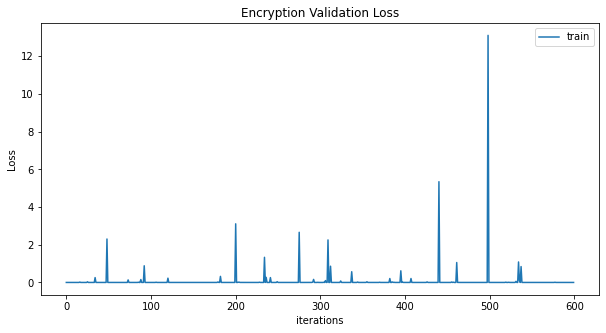

In [25]:
plt.figure(figsize=(10,5))
plt.title("Encryption Validation Loss")

plt.plot(enc_val_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

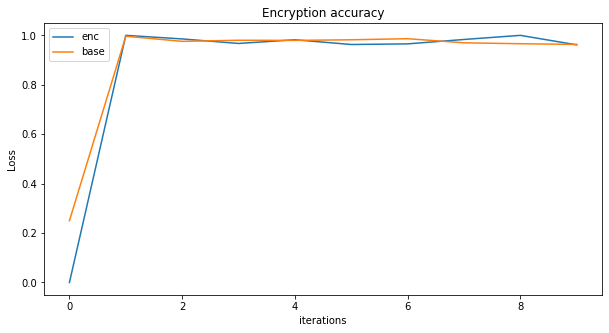

In [36]:
plt.figure(figsize=(10,5))
plt.title("Encryption accuracy")

plt.plot(enc_acc,label="enc")
plt.plot(acc,label = "base")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()